In [1]:
import cv2
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt 

Matplotlib is building the font cache; this may take a moment.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.morphology import disk
from skimage.filters.rank import mean
from PIL import Image
from skimage import img_as_ubyte

In [2]:
path_image = '/Users/yabserabekele/Downloads/Lesion_images/testimage.jpeg'

In [3]:
def display_image(image):
    plt.imshow(image, cmap='gray') 
    plt.axis('off') 
    plt.show()

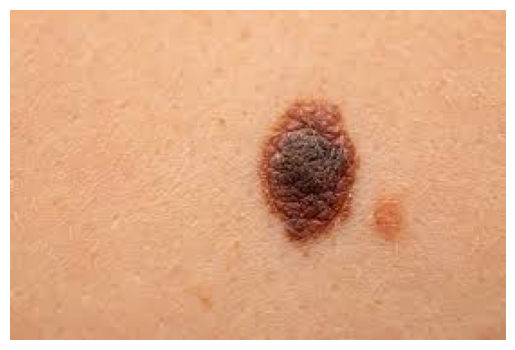

In [4]:
image = Image.open(path_image)
display_image(image)

In [5]:
def preprocess_image(image_path):
    # Step 1: Read the image
    image = cv2.imread(image_path)
    
    # Step 2: Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Step 3: Apply median blur to the grayscale image
    median_filtered_image = cv2.medianBlur(gray_image, 5)
    
    # Step 4: Create a structuring element (kernel) for morphological operation
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))
    
    # Step 5: Apply blackhat morphological operation to highlight hair
    bottom_hat = cv2.morphologyEx(median_filtered_image, cv2.MORPH_BLACKHAT, kernel)
    
    # Step 6: Threshold the blackhat result to create a binary hair mask
    _, hair_mask = cv2.threshold(bottom_hat, 2, 255, cv2.THRESH_BINARY)
    
    # Step 7: Inpaint the image using the hair mask to remove hair
    inpainted_image = cv2.inpaint(median_filtered_image, hair_mask, 3, cv2.INPAINT_TELEA) 
        
    return inpainted_image


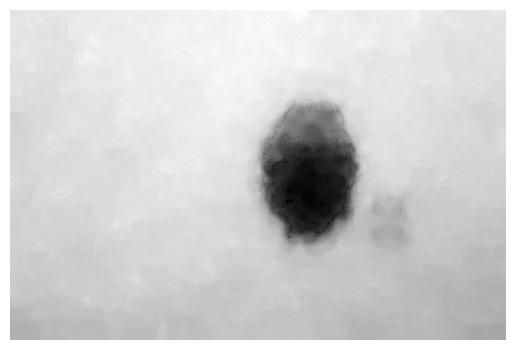

In [6]:
image_preprocess = preprocess_image(path_image)
display_image(image_preprocess)

In [7]:
from skimage import img_as_float
from skimage.segmentation import chan_vese
def gac_segmentation(image):
    image = img_as_float(image)
    segmented_image = chan_vese(image, mu=0.5, lambda1=1, lambda2=1, tol=1e-3, max_num_iter=100,
                                dt=0.5, init_level_set="checkerboard", extended_output=True)
    
    return segmented_image[0]

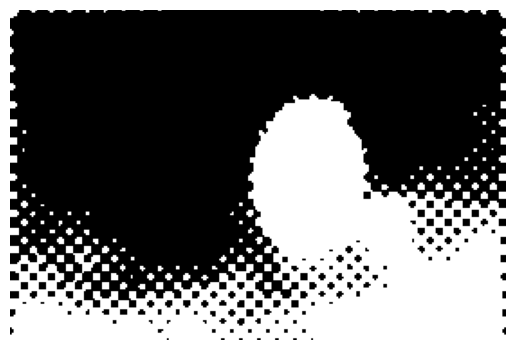

In [8]:
image_segmentation = gac_segmentation(image_preprocess)
display_image(image_segmentation)

In [11]:



def d2Kmeans(img, k):
    return KMeans(n_clusters=k, random_state=1, init="k-means++").fit(img.reshape((-1, 1))).labels_.reshape(img.shape)

def merge_segmented_mask_ROI(uri_img, img_kluster):
    new_img = np.zeros_like(uri_img)
    for ch in range(3):
        new_img[:, :, ch] = img_kluster * 255  # Convert mask to white
    return new_img

def mean_filter(image, radius):
    # Convert image to uint8
    image_uint8 = img_as_ubyte(image)
    
    # Apply mean filter
    return mean(image_uint8, footprint=disk(radius))

def binary(image):
    return image > threshold_otsu(image)

def select_cluster_index(clusters):
    minx = clusters[0].mean()
    index = 0
    for i, cluster in enumerate(clusters):
        if cluster.mean() < minx:
            minx = cluster.mean()
            index = i
    return index

def segment_image(img, k=2):
    # Cluster the image
    result_gray = d2Kmeans(rgb2gray(img), k)
    
    # Select the correct cluster
    clusters_gray = [result_gray == i for i in range(k)]
    selected_index = select_cluster_index(clusters_gray)
    results_gray = clusters_gray[selected_index]
    
    # Apply smoothing of the boundaries
    image_mean_filter = mean_filter(results_gray, 20)
    test_binary = binary(image_mean_filter)
    
    # Create segmented picture with black background and white object
    new_img = merge_segmented_mask_ROI(img, test_binary)
    
    return new_img

In [12]:
img = segment_image(image)

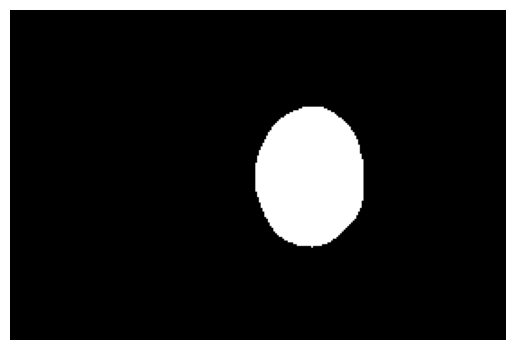

In [13]:
display_image(img)

## Pixel conversion and Area Calculation

In [14]:


# Load the binary mask (output from your segmentation model)
mask = img

# Calculate the area in pixels
area_in_pixels = np.sum(mask == 255)  # Assuming lesion is represented by 255

# Pixel size (calibrated from the image)
pixel_size_mm = 0.1  # Example: 0.1 mm/pixel

# Convert to real-world area
true_surface_area_mm2 = area_in_pixels * (pixel_size_mm ** 2)

print(f"True Surface Area: {true_surface_area_mm2} mm²")

True Surface Area: 110.76000000000002 mm²
